<a href="https://colab.research.google.com/github/clementlemon02/AAPL-Stock-Price-Prediction/blob/main/AAPL-Stock-Price-Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Functions used

In [ ]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import mplfinance as mpf
import seaborn as sns
from bokeh.plotting import figure, show, output_notebook
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
import torch


In [ ]:
def mean_squared_error(y_true, y_pred):
    """
    Calculate Mean Squared Error (MSE) without using sklearn.

    Parameters:
    - y_true (array-like): True target values.
    - y_pred (array-like): Predicted target values.

    Returns:
    - mse (float): Mean Squared Error.
    """
    # Calculate squared errors
    errors = (y_true - y_pred) ** 2
    # Calculate mean squared error
    mse = np.mean(errors)
    return mse

def mean_absolute_error(y_true, y_pred):
    """
    Calculate Mean Absolute Error (MAE) without using sklearn.

    Parameters:
    - y_true (array-like): True target values.
    - y_pred (array-like): Predicted target values.

    Returns:
    - mae (float): Mean Absolute Error.
    """
    # Calculate absolute errors
    errors = np.abs(y_true - y_pred)
    # Calculate mean absolute error
    mae = np.mean(errors)
    return mae

def r_squared(y_true, y_pred):
    """
    Calculate R-squared without using sklearn.

    Parameters:
    - y_true (array-like): True target values.
    - y_pred (array-like): Predicted target values.

    Returns:
    - r_squared (float): R-squared.
    """
    # Calculate mean of true values
    y_true_mean = np.mean(y_true)
    # Calculate total sum of squares
    ss_total = np.sum((y_true - y_true_mean) ** 2)
    # Calculate residual sum of squares
    ss_res = np.sum((y_true - y_pred) ** 2)
    # Calculate R-squared
    r_squared = 1 - (ss_res / ss_total)
    return r_squared

def standard_scaler(X_train, X_test):
  '''
  A function to standardise the data based on the training set,
  and transform the test set by standardisation.

  Parameters:
    X_train (array-like): Training data
    X_test (array-like) : Test data

  Returns:
    X_train (array-like): Standardised training data
    X_test (array-like) : Test data, standardised by the mean & std of the training data
  '''
  mean = np.mean(X_train, axis = 0)
  std = np.std(X_train, axis = 0)
  X_train = (X_train - mean) / std
  X_test = (X_test - mean) / std
  return X_train, X_test

# Importing the Dataset using `yfinance`

In [ ]:
df = yf.download('AAPL')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.098943,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093781,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086898,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089049,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091630,73449600
...,...,...,...,...,...,...
2024-09-11,221.460007,223.089996,217.889999,222.660004,222.660004,44587100
2024-09-12,222.500000,223.550003,219.820007,222.770004,222.770004,37498200
2024-09-13,223.580002,224.039993,221.910004,222.500000,222.500000,36766600


# Feature Engineering: Add Indicators

### Add Commodity Channel Index (CCI)

In [ ]:
def CCI(df, ndays):
  tp = (df['High'] + df['Low'] + df['Close']) / 3 # true price
  sma = tp.rolling(ndays).mean() # simple moving average
  mad = tp.rolling(ndays).apply(lambda x: (pd.Series(x) - pd.Series(x).mean()).abs().mean()) # mean average deviation
  cci = (tp - sma) / (0.015 * mad)
  return cci

df['cci_7'] = CCI(df, 7)
df['cci_14'] = CCI(df, 14)

### Add Rolling Moving Average (RMA)

In [ ]:
change = df['Close'].diff()
gain = change.mask(change < 0, 0.0) # if change is negative, this is 0
loss = -change.mask(change > 0, -0.0) # if change is positive, this is 0

def rma(x, n):
    """Running moving average"""
    a = np.full_like(x, np.nan)
    a[n-1] = x[:n].mean()
    for i in range(n, len(x)):
        a[i] = (a[i-1] * (n - 1) + x[i]) / n
    return a

avg_gain = rma(gain, 7)
avg_loss = rma(loss, 7)

rs = avg_gain / avg_loss
df['rsi_7'] = 100 - (100 / (1 + rs))

avg_gain = rma(gain, 14)
avg_loss = rma(loss, 14)

rs = avg_gain / avg_loss
df['rsi_14'] = 100 - (100 / (1 + rs))

# https://smartasset.com/investing/what-is-rsi

<ipython-input-6-58a22d1fd0f3>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a[i] = (a[i-1] * (n - 1) + x[i]) / n
<ipython-input-6-58a22d1fd0f3>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a[i] = (a[i-1] * (n - 1) + x[i]) / n


### Add Simple Moving Average (SMA)

In [ ]:
def sma(prices, period):
  sma_arr = np.zeros(len(prices))
  for i in range(period - 1, len(prices)):
    sma_arr[i] = np.mean(prices[(i+1-period):i+1])
  return sma_arr

df['sma_50'] = sma(df['Close'], 50)
df['sma_100'] = sma(df['Close'], 100)
df['Bolling'] = sma(df['Close'], 20)

### Add Exponential Moving Average (EMA) & Moving Average Converge/Divergence (MACD)

In [ ]:
def exponential_moving_average(prices, period, weighting_factor):
  ema = np.zeros(len(prices))
  sma = np.mean(prices[:period])
  ema[period - 1] = sma
  for i in range(period, len(prices)):
    ema[i] = (prices[i] * weighting_factor) + (ema[i - 1] * (1 - weighting_factor))
  return ema

df['ema_50'] = exponential_moving_average(df['Close'], 50, 2/51)
df['ema_100'] = exponential_moving_average(df['Close'], 100, 2/101)
df['MACD'] = df['ema_50'] - df['ema_100']

# https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp

<ipython-input-8-9d7ba8e54d51>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ema[i] = (prices[i] * weighting_factor) + (ema[i - 1] * (1 - weighting_factor))
<ipython-input-8-9d7ba8e54d51>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ema[i] = (prices[i] * weighting_factor) + (ema[i - 1] * (1 - weighting_factor))


### Add True Range (TR) & Average True Range (ATR)

In [ ]:
def true_range(df):
  prev_close = df['Close'].shift(1)
  high_low = df['High'] - df['Low']
  high_close = abs(df['High'] - prev_close)
  low_close = abs(df['Low'] - prev_close)
  new_df = pd.concat([high_low, high_close, low_close], axis = 1)
  tr = new_df.max(axis = 1)
  return tr

df['TR'] = true_range(df)
df['atr_7'] = rma(df['TR'], 7)
df['atr_14'] = rma(df['TR'], 14)

# https://www.wallstreetmojo.com/average-true-range/

<ipython-input-6-58a22d1fd0f3>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a[i] = (a[i-1] * (n - 1) + x[i]) / n
<ipython-input-6-58a22d1fd0f3>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a[i] = (a[i-1] * (n - 1) + x[i]) / n


### Add Next Day Close

In [ ]:
df['Close_next_day'] = df['Close'].shift(-1)

In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,cci_7,cci_14,rsi_7,rsi_14,sma_50,sma_100,Bolling,ema_50,ema_100,MACD,TR,atr_7,atr_14,Close_next_day
count,11032.000000,11032.000000,11032.000000,11032.000000,11032.000000,1.103200e+04,11026.000000,11019.000000,11026.000000,11019.000000,11032.000000,11032.000000,11032.000000,11032.000000,11032.000000,11032.000000,11032.000000,11026.000000,11019.000000,11031.000000
mean,22.911492,23.158014,22.674243,22.926226,22.110310,3.172513e+08,8.563244,13.359540,53.153010,53.117024,22.432976,21.946840,22.735048,22.438997,21.977806,0.461191,0.536126,0.533920,0.531127,22.928293
std,47.236262,47.741418,46.759934,47.273416,46.821641,3.352687e+08,100.738655,109.633179,17.660637,13.027558,46.270709,45.296680,46.887845,46.262168,45.365724,1.656115,1.280087,1.152845,1.132674,47.275061
min,0.049665,0.049665,0.049107,0.049107,0.037856,0.000000e+00,-233.333333,-379.928972,5.153518,15.346105,0.000000,0.000000,0.000000,0.000000,0.000000,-6.250353,0.000000,0.001010,0.001172,0.049107
25%,0.299107,0.305246,0.291714,0.299107,0.242580,1.125552e+08,-77.455392,-73.579924,39.839769,43.492219,0.302503,0.300668,0.299958,0.303421,0.303060,-0.006508,0.009464,0.011214,0.011432,0.299107
50%,0.533761,0.541574,0.526786,0.533482,0.435709,2.049374e+08,17.432670,22.934271,53.114108,52.976769,0.526462,0.510402,0.532087,0.523828,0.502545,0.013337,0.026786,0.023574,0.023160,0.533482
75%,20.516430,20.627856,20.326339,20.435268,17.497311,3.980466e+08,92.332147,98.913553,66.727025,62.722092,20.395073,19.754775,20.231322,20.243463,19.508122,0.331242,0.349642,0.390734,0.390131,20.436250
max,236.479996,237.229996,233.089996,234.820007,234.548523,7.421641e+09,233.333333,441.932309,96.449018,91.502574,223.088201,209.458501,225.207500,219.507922,211.248421,11.481774,23.860001,8.395800,6.920489,234.820007


In [ ]:
all_features = df.columns.tolist()
print("All features in the DataFrame:", all_features)

All features in the DataFrame: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'cci_7', 'cci_14', 'rsi_7', 'rsi_14', 'sma_50', 'sma_100', 'Bolling', 'ema_50', 'ema_100', 'MACD', 'TR', 'atr_7', 'atr_14', 'Close_next_day']


## Split into Train, Test & Validation Set

In [ ]:
train_start_date = pd.to_datetime('2010')
val_start_date = pd.to_datetime('2022')
test_start_date = pd.to_datetime('2023')
test_end_date = pd.to_datetime('2024')

df = df.loc[train_start_date:test_end_date]

df_train = df.loc[:val_start_date]
df_val = df.loc[val_start_date:test_start_date]
df_test = df.loc[test_start_date:]

df_val

,Open,High,Low,Close,Adj Close,Volume,cci_7,cci_14,rsi_7,rsi_14,sma_50,sma_100,Bolling,ema_50,ema_100,MACD,TR,atr_7,atr_14,Close_next_day
Date,,,,,,,,,,,,,,,,,,,,
2022-01-03,177.830002,182.880005,177.710007,182.009995,179.273590,104487900,124.954519,108.733381,69.589049,66.600031,162.748201,155.001400,175.4900,165.606201,157.328560,8.277641,5.309998,3.787781,4.075262,179.699997
2022-01-04,182.630005,182.940002,179.119995,179.699997,176.998337,99310400,95.834024,87.879008,59.412780,61.901244,163.368401,155.309500,176.2090,166.158899,157.771559,8.387340,3.820007,3.792385,4.057029,174.919998
2022-01-05,179.610001,180.169998,174.639999,174.919998,172.290192,94537600,-153.516237,1.302683,43.910934,53.491262,163.894001,155.567700,176.3960,166.502472,158.111132,8.391340,5.529999,4.040615,4.162241,172.000000
2022-01-06,172.699997,175.300003,171.639999,172.000000,169.414108,96904000,-173.616793,-71.654920,37.025837,49.102530,164.347601,155.776500,176.2420,166.718061,158.386159,8.331902,3.660004,3.986242,4.126367,172.169998
2022-01-07,172.889999,174.139999,171.029999,172.169998,169.581543,86709100,-115.521980,-86.626967,37.689439,49.363007,164.814001,155.996300,176.1225,166.931863,158.659106,8.272756,3.110001,3.861065,4.053770,172.190002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,130.631363,63814900,-85.555578,-101.644184,29.429344,35.675357,144.131800,150.515600,140.6610,143.461739,147.002104,-3.540366,2.779999,4.293891,4.457866,130.029999
2022-12-27,131.380005,131.410004,128.720001,130.029999,128.818420,69007800,-117.979203,-101.949857,25.760901,33.658569,143.964799,150.157800,139.9515,142.935004,146.666023,-3.731019,3.139999,4.129049,4.363733,126.040001
2022-12-28,129.669998,131.029999,125.870003,126.040001,124.865585,85438400,-159.527554,-114.020379,19.559098,29.714325,143.637399,149.764699,139.1950,142.272455,146.257587,-3.985132,5.159996,4.276327,4.420609,129.610001


In [ ]:
df_train


,Open,High,Low,Close,Adj Close,Volume,cci_7,cci_14,rsi_7,rsi_14,sma_50,sma_100,Bolling,ema_50,ema_100,MACD,TR,atr_7,atr_14,Close_next_day
Date,,,,,,,,,,,,,,,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.454506,493729600,94.990182,104.544342,75.461597,67.302449,7.131179,6.753946,7.145232,7.074913,6.690853,0.384060,0.134643,0.142267,0.149661,7.656429
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.465664,601904800,120.368800,94.633998,76.009198,67.650241,7.137736,6.771471,7.182839,7.097718,6.709974,0.387744,0.083572,0.133882,0.144940,7.534643
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.362819,552160000,14.111103,66.376744,61.300582,61.190503,7.142757,6.786668,7.222161,7.114852,6.726304,0.388548,0.160000,0.137613,0.146016,7.520714
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.351057,477131200,-67.715175,43.383503,59.757530,60.479173,7.148543,6.802311,7.259143,7.130768,6.742035,0.388734,0.105358,0.133005,0.143112,7.570714
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.393280,447610800,-54.270437,42.188365,63.595152,62.178777,7.158979,6.821021,7.284464,7.148021,6.758444,0.389577,0.105000,0.129005,0.140390,7.503929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,177.089996,180.419998,177.070007,180.330002,177.618881,74919600,137.386186,135.922937,69.613272,66.890408,159.597001,153.344400,171.463000,162.569367,155.017209,7.552158,4.139999,4.512505,4.521509,179.289993
2021-12-28,180.160004,181.330002,178.529999,179.289993,176.594498,79144300,105.373432,127.057583,65.638116,64.950263,160.286001,153.666700,172.415500,163.225078,155.497858,7.727220,2.800003,4.267862,4.398544,179.380005
2021-12-29,179.330002,180.630005,178.139999,179.380005,176.683151,62348900,73.556164,98.104428,65.835109,65.044762,160.942601,153.999100,173.119500,163.858604,155.970772,7.887833,2.490005,4.013882,4.262220,178.199997


# Visualizations

In [ ]:
!pip -q install mplfinance
!pip -q install bokeh


              Open         High          Low        Close    Adj Close  \
count  3522.000000  3522.000000  3522.000000  3522.000000  3522.000000   
mean     59.883701    60.528731    59.267621    59.926226    57.701397   
std      55.387520    56.014467    54.812449    55.444533    55.642305   
min       6.870357     7.000000     6.794643     6.858929     5.792195   
25%      19.680447    19.832321    19.402321    19.608571    16.986198   
50%      32.303749    32.633751    32.078751    32.340000    29.103412   
75%      91.213125    92.512501    90.425623    91.207499    88.971643   
max     198.020004   199.619995   197.000000   198.110001   197.361084   

             Volume        cci_7       cci_14        rsi_7       rsi_14  \
count  3.522000e+03  3522.000000  3522.000000  3522.000000  3522.000000   
mean   2.422834e+08    16.658743    24.348823    55.784465    55.458505   
std    2.204578e+08   100.580668   108.336373    17.836058    12.986079   
min    2.404830e+07  -233.333333 

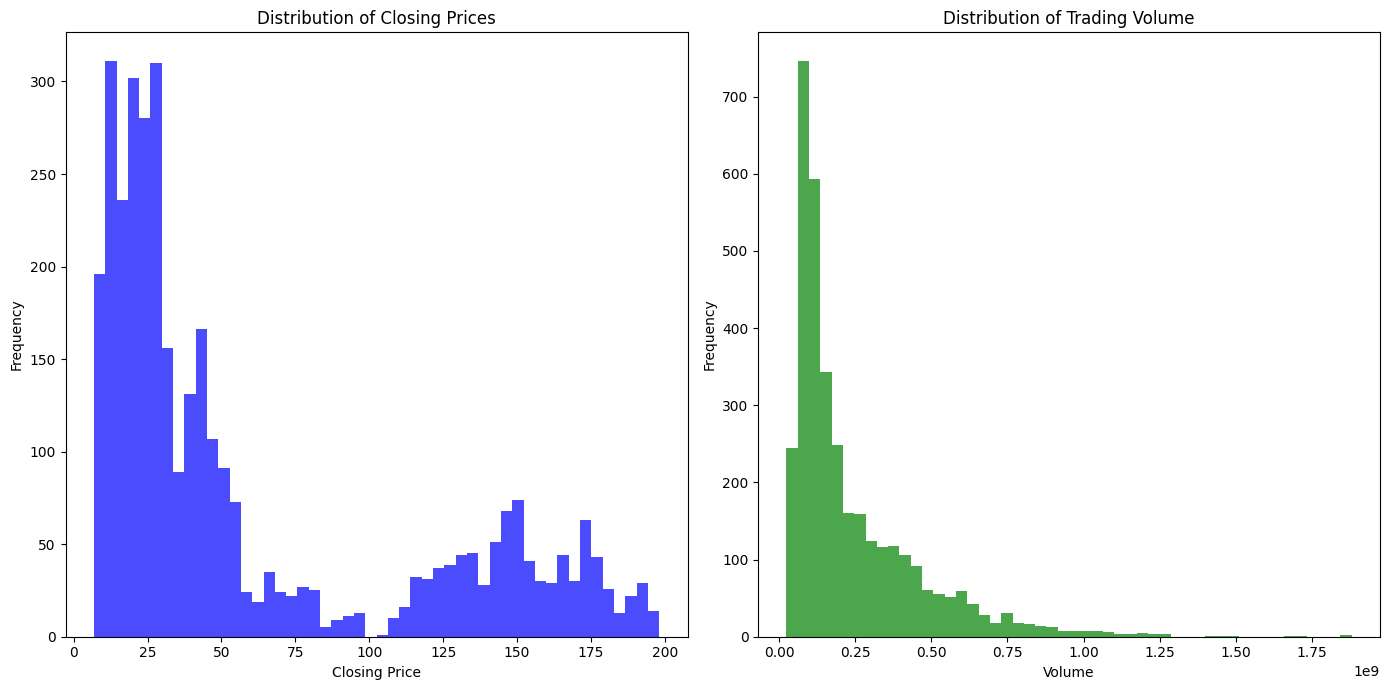

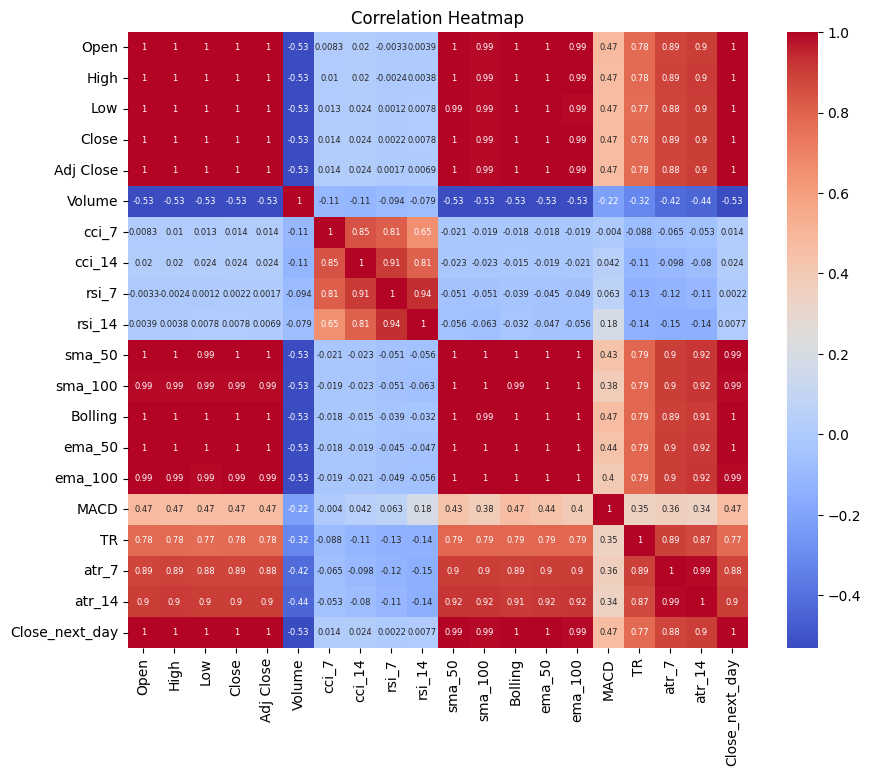

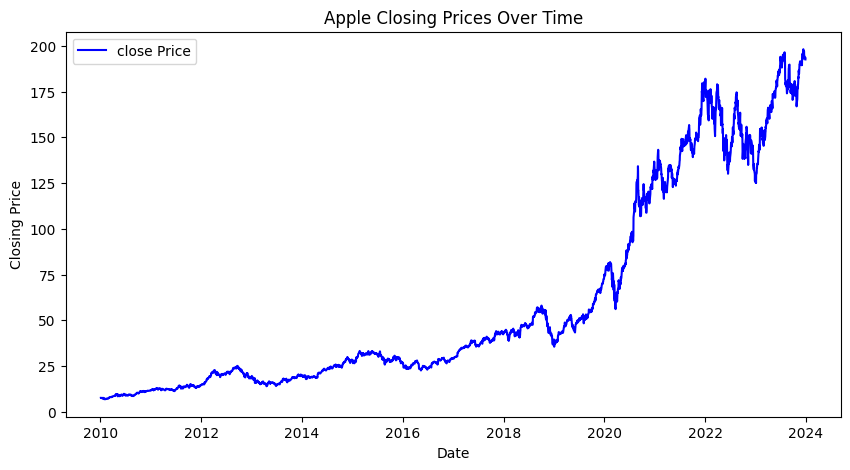

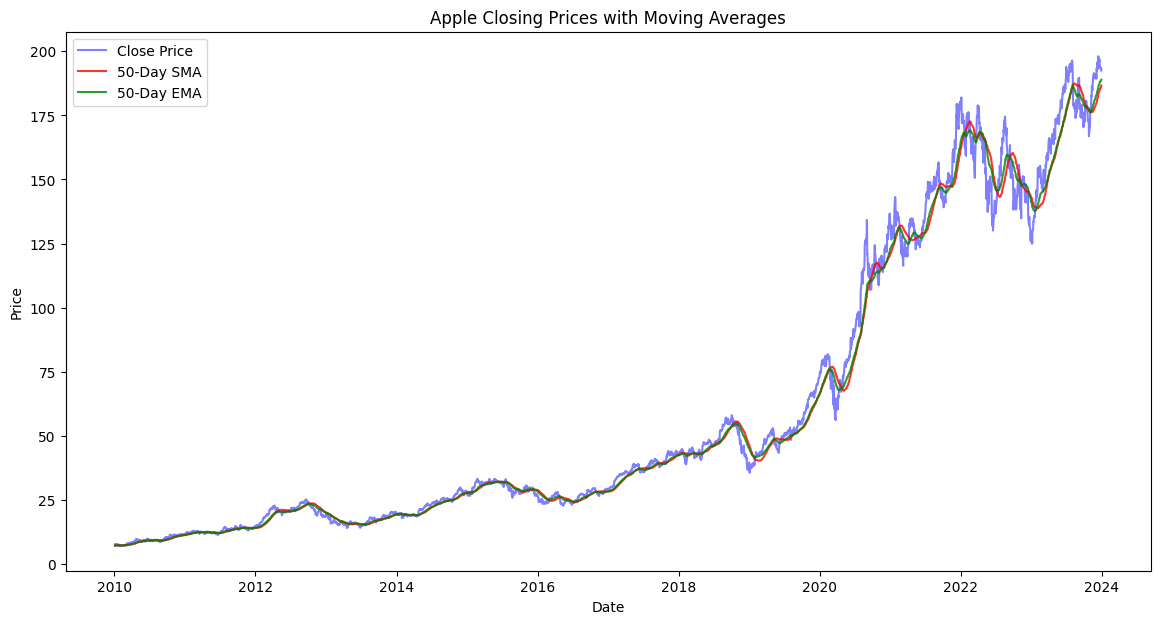

<ipython-input-16-6d2205e2d5ca>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['middle_band'] = df['sma_50']
<ipython-input-16-6d2205e2d5ca>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['upper_band'] = df['middle_band'] + 2 * df['Close'].rolling(50).std()
<ipython-input-16-6d2205e2d5ca>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

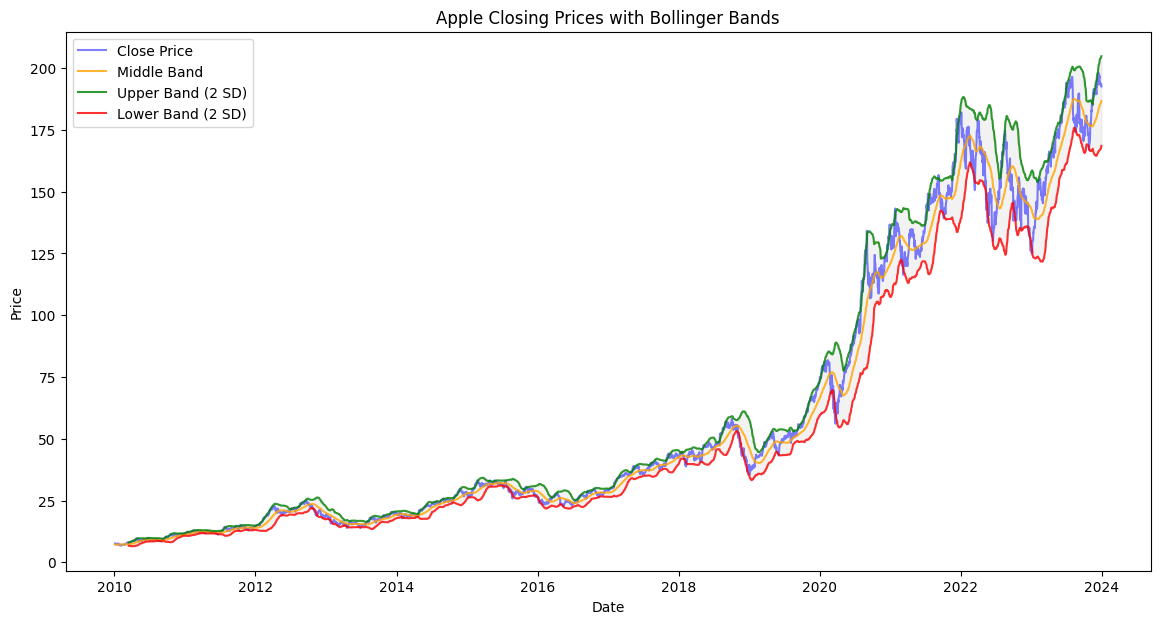

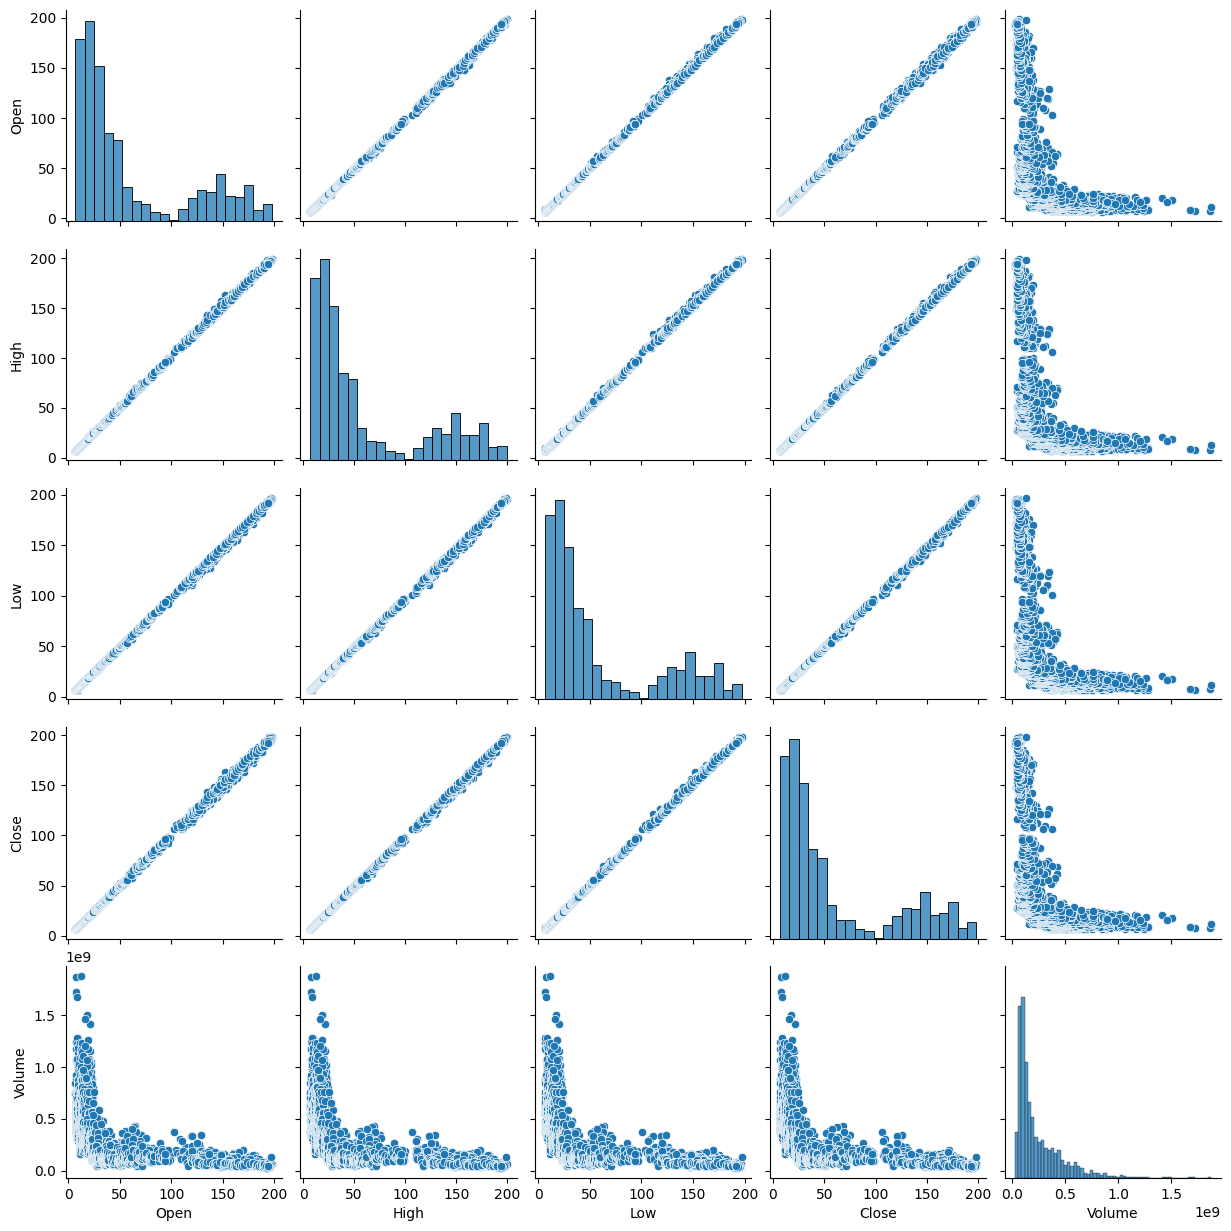

In [ ]:
### Basic Data Description
print(df.describe())

### Distribution of Closing Price and Volume
plt.figure(figsize=(14, 7))

# Subplot 1: Closing prices
plt.subplot(1, 2, 1)
plt.hist(df['Close'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')

# Subplot 2: Volume
plt.subplot(1, 2, 2)
plt.hist(df['Volume'], bins=50, color='green', alpha=0.7)
plt.title('Distribution of Trading Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 6})  # You can adjust the size value as needed
plt.title('Correlation Heatmap')
plt.show()


### Closing Trend Price Over Time
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Close'], label='close Price', color='blue')
plt.title('Apple Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

### Moving Price Averages over time
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', color='blue', alpha=0.5)
plt.plot(df.index, df['sma_50'], label='50-Day SMA', color='red', alpha=0.8)
plt.plot(df.index, df['ema_50'], label='50-Day EMA', color='green', alpha=0.8)
plt.title('Apple Closing Prices with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Bollinger Bands Visualisations
# Calculate Bollinger Bands
df['middle_band'] = df['sma_50']
df['upper_band'] = df['middle_band'] + 2 * df['Close'].rolling(50).std()
df['lower_band'] = df['middle_band'] - 2 * df['Close'].rolling(50).std()

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', color='blue', alpha=0.5)
plt.plot(df.index, df['middle_band'], label='Middle Band', color='orange', alpha=0.8)
plt.plot(df.index, df['upper_band'], label='Upper Band (2 SD)', color='green', alpha=0.8)
plt.plot(df.index, df['lower_band'], label='Lower Band (2 SD)', color='red', alpha=0.8)
plt.fill_between(df.index, df['upper_band'], df['lower_band'], color='grey', alpha=0.1)
plt.title('Apple Closing Prices with Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Pair Plot
sns.pairplot(df[['Open', 'High', 'Low', 'Close', 'Volume']])
plt.show()


In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume,cci_7,cci_14,rsi_7,rsi_14,...,ema_50,ema_100,MACD,TR,atr_7,atr_14,Close_next_day,middle_band,upper_band,lower_band
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.454506,493729600,94.990182,104.544342,75.461597,67.302449,...,7.074913,6.690853,0.384060,0.134643,0.142267,0.149661,7.656429,7.131179,NaN,NaN
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.465664,601904800,120.368800,94.633998,76.009198,67.650241,...,7.097718,6.709974,0.387744,0.083572,0.133882,0.144940,7.534643,7.137736,NaN,NaN
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.362819,552160000,14.111103,66.376744,61.300582,61.190503,...,7.114852,6.726304,0.388548,0.160000,0.137613,0.146016,7.520714,7.142757,NaN,NaN
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.351057,477131200,-67.715175,43.383503,59.757530,60.479173,...,7.130768,6.742035,0.388734,0.105358,0.133005,0.143112,7.570714,7.148543,NaN,NaN
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.393280,447610800,-54.270437,42.188365,63.595152,62.178777,...,7.148021,6.758444,0.389577,0.105000,0.129005,0.140390,7.503929,7.158979,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,192.868134,37122800,-125.833259,-50.518148,43.616383,54.609714,...,188.226229,183.982764,4.243465,2.440002,2.744972,2.790613,193.050003,185.398801,203.729426,167.068175
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.320221,28919300,-128.310836,-89.108633,40.755941,53.026883,...,188.415396,184.162313,4.253083,1.059998,2.504262,2.666998,193.149994,185.682801,204.039285,167.326317
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.419830,48087700,-115.745603,-116.860552,41.568717,53.291938,...,188.601067,184.340287,4.260780,2.410004,2.490796,2.648641,193.580002,185.971400,204.334807,167.607994


# Feature Selection

In [ ]:
feature_selection = {}

## Feature Selection of Apple Dataset (Mutual Info)

In [ ]:
# Information Gain
from sklearn.feature_selection import mutual_info_regression

In [ ]:
df_train = df_train.dropna()
X = df_train.drop(['Close_next_day'], axis = 1)
y = df_train['Close_next_day']
print(y)

Date
2010-01-04      7.656429
2010-01-05      7.534643
2010-01-06      7.520714
2010-01-07      7.570714
2010-01-08      7.503929
                 ...    
2021-12-27    179.289993
2021-12-28    179.380005
2021-12-29    178.199997
2021-12-30    177.570007
2021-12-31    182.009995
Name: Close_next_day, Length: 3021, dtype: float64


<Axes: >

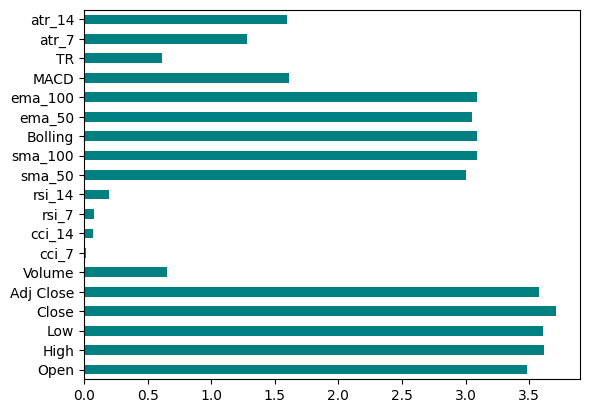

In [ ]:
importances = mutual_info_regression(X, y)
feat_importances = pd.Series(importances, X.columns)
feat_importances.plot(kind ="barh", color = "teal")

In [ ]:
feat_importances.sort_values(ascending=False)

,0
Close,3.714155
High,3.616050
Low,3.607609
Adj Close,3.577068
Open,3.480515
ema_100,3.093488
sma_100,3.091310
Bolling,3.090576
ema_50,3.048487
sma_50,3.000592


In [ ]:
feature_selection['info_gain'] = list(feat_importances.nlargest(7).index)
feature_selection['info_gain']

['Close', 'High', 'Low', 'Adj Close', 'Open', 'ema_100', 'sma_100']

## Feature Selection of Apple Dataset (f-test)


In [ ]:
df_train = df_train.dropna()

features = df_train.drop(['Close_next_day'], axis = 1).values
target = df_train['Close_next_day'].values

# feature extraction
test = SelectKBest(score_func=f_regression, k=4)
fit = test.fit(features, target)

In [ ]:
## summarize scores
print("Univariate Selection")
np.set_printoptions(precision=3)
print(fit.scores_)

Univariate Selection
[2.401e+06 2.989e+06 3.305e+06 3.739e+06 3.169e+06 9.037e+02 1.065e+01
 2.249e+01 1.523e+01 2.717e+01 2.658e+05 1.673e+05 6.215e+05 3.856e+05
 2.370e+05 3.876e+03 4.075e+03 9.733e+03 1.214e+04]


In [ ]:
feature_names = df_train.columns.tolist()
values = np.array(fit.scores_)
highest_indices = np.argsort(values)[-7:]
optimal_features = [feature_names[i] for i in highest_indices]
index=[]
for idx, feature_name in zip(highest_indices, optimal_features):
    print(f"Index: {idx}, Feature Name: {feature_name}")
    index.append(idx)

index.sort()
feature_selection['univariate'] = optimal_features # store the optimal features from univariate selection in a list

Index: 13, Feature Name: ema_50
Index: 12, Feature Name: Bolling
Index: 0, Feature Name: Open
Index: 1, Feature Name: High
Index: 4, Feature Name: Adj Close
Index: 2, Feature Name: Low
Index: 3, Feature Name: Close


In [ ]:
optimal_features

['ema_50', 'Bolling', 'Open', 'High', 'Adj Close', 'Low', 'Close']

In [ ]:
optimal_columns = df_train.iloc[:, index]
print(optimal_columns)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-01-04    7.622500    7.660714    7.585000    7.643214    6.454506   
2010-01-05    7.664286    7.699643    7.616071    7.656429    6.465664   
2010-01-06    7.656429    7.686786    7.526786    7.534643    6.362819   
2010-01-07    7.562500    7.571429    7.466071    7.520714    6.351057   
2010-01-08    7.510714    7.571429    7.466429    7.570714    6.393280   
...                ...         ...         ...         ...         ...   
2021-12-27  177.089996  180.419998  177.070007  180.330002  177.618881   
2021-12-28  180.160004  181.330002  178.529999  179.289993  176.594498   
2021-12-29  179.330002  180.630005  178.139999  179.380005  176.683151   
2021-12-30  179.470001  180.570007  178.089996  178.199997  175.520874   
2021-12-31  178.089996  179.229996  177.259995  177.570007  174.900375   

               Bolling      ema_50  


# Linear Regression

<ipython-input-29-a92e40f81b65>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)  # Removing NaN values


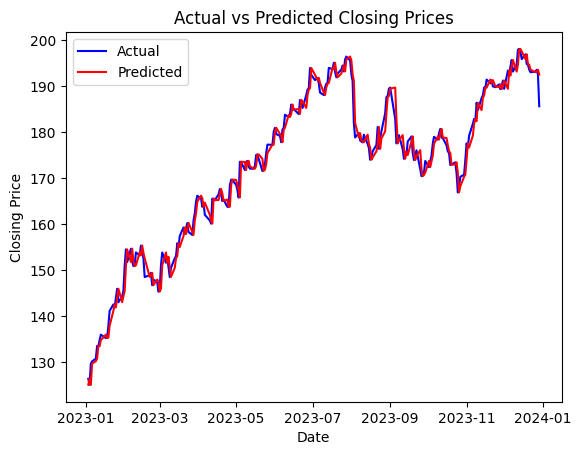

MSE:  4.721547933882015
R-squared:  0.9996860059448144


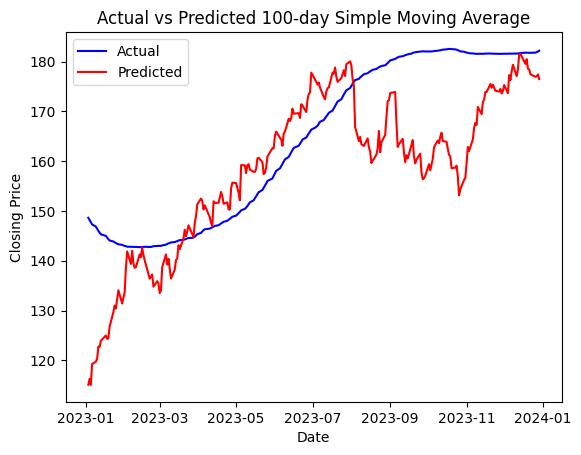

Intercept: 1.3667618556652803
Coefficient: 0.9094630180342376
Mean Squared Error: 158.17261012331082
R^2 Score: 0.3917329666878603


In [ ]:
## Predicting tomorrow's opening price and today's closing price
df.dropna(inplace=True)  # Removing NaN values

train = pd.concat([df_train, df_val])


X_train = train['Close'].values  # Independent variable
y_train = train['Close_next_day'].values  # Dependent variable (target)
train_dates = train.index

X_test = df_test['Close'].values
y_test = df_test['Close_next_day'].values
test_dates = df_test.index

# Calculate means
X_mean = np.mean(X_train)
y_mean = np.mean(y_train)

# Calculate beta_1 (slope) and beta_0 (intercept)
numerator = np.sum((X_train - X_mean) * (y_train - y_mean))
denominator = np.sum((X_train - X_mean) ** 2)
beta_1 = numerator / denominator
beta_0 = y_mean - beta_1 * X_mean

# Making predictions
y_pred = beta_0 + beta_1 * X_test

# Plot
# plt.scatter(X, y, color='blue', label='Actual')
plt.plot(test_dates, y_test, color='blue', label='Actual')
plt.plot(test_dates, y_pred, color='red', label='Predicted')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

mse = np.mean((y_test - y_pred) ** 2)
mae = np.mean(np.abs(y_test - y_pred))
rmspe = np.sqrt(np.mean((y_test - y_pred) ** 2)) / y_mean * 100
r2 = 1 - (np.sum((y_test - y_pred) ** 2) / np.sum((y_test - y_mean) ** 2))
print("MSE: ", mse)
print("R-squared: ", r2)

## Predicting sma_100 with closing values

# Calculate the rolling mean of 'close' over 100 days to use as the new X

# Define the independent variable (features)
X = df_train['Close'].values.reshape(-1, 1)  # Rolling mean as features
# Add a column of ones to X to account for the intercept (beta_0)
X = np.append(arr=np.ones((X.shape[0], 1)).astype(int), values=X, axis=1)

# Define the dependent variable (target)
y = df_train['sma_100'].values  # SMA_100 as the target

# Calculate the coefficients using the OLS formula
X_transpose = X.T
beta = np.linalg.inv(X_transpose.dot(X)).dot(X_transpose).dot(y)

# Making predictions and evaluating the model
X_test = df_test['Close'].values.reshape(-1, 1)
X_test = np.append(arr = np.ones((X_test.shape[0], 1)).astype(int), values = X_test, axis = 1)
y_test = df_test['sma_100'].values
y_pred = X_test.dot(beta)
mse = np.mean((y_test - y_pred)**2)
variance = np.var(y_test)
r2 = 1 - (mse / variance)

# Plot
# plt.scatter(X, y, color='blue', label='Actual')
plt.plot(test_dates, y_test, color='blue', label='Actual')
plt.plot(test_dates, y_pred, color='red', label='Predicted')
plt.title('Actual vs Predicted 100-day Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# The beta array holds the coefficients/weights of each feature and the intercept
intercept = beta[0]
coefficient = beta[1]
print(f'Intercept: {intercept}')
print(f'Coefficient: {coefficient}')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')



# Multiple Linear Regression

Intercept: 51.35707397157816
Coefficients: [  0.15    0.59  -19.992  15.523   1.21   22.87   26.991]
Mean Squared Error: 4.934879913370379
R^2 Score: 0.9830296995146411


<ipython-input-30-509836998a0c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
<ipython-input-30-509836998a0c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-30-509836998a0c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


Text(0, 0.5, 'Price')

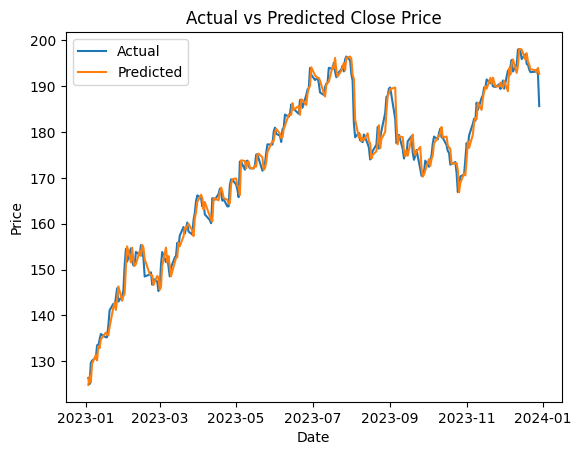

In [ ]:
# Load data, ensure no missing or infinite values
df.dropna(inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Scaling the features
scaler = StandardScaler()
univariate_selection = ['ema_50', 'Bolling', 'Open', 'High', 'Adj Close', 'Low', 'Close']
X_train = pd.concat([df_train[univariate_selection], df_val[univariate_selection]])
train_dates = X_train.index
# print(X)
X_train = scaler.fit_transform(X_train)
X_train = np.append(arr=np.ones((X_train.shape[0], 1)), values=X_train, axis=1) # add a bias term

X_test = df_test[univariate_selection]
test_dates = X_test.index
X_test = scaler.transform(X_test)
X_test = np.append(arr=np.ones((X_test.shape[0], 1)), values=X_test, axis=1) # add a bias term


y_train = pd.concat([df_train['Close_next_day'], df_val['Close_next_day']])
y_test = df_test['Close_next_day']
# print(y)

# Calculate the coefficients using the OLS formula
X_transpose = X_train.T
beta = np.linalg.inv(X_transpose.dot(X_train)).dot(X_transpose).dot(y_train)

# Outputs
intercept = beta[0]
coefficients = beta[1:]
print(f'Intercept: {intercept}')
print(f'Coefficients: {coefficients}')

# Making predictions and evaluating the model
y_pred = X_test.dot(beta)
mse = np.mean((y_test - y_pred)**2)
variance = np.var(y_test)
r2 = 1 - (mse / variance)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

plt.plot(test_dates, y_test)
plt.plot(test_dates, y_pred)
plt.legend(['Actual', 'Predicted'])
plt.title('Actual vs Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Price')

# Lasso Regression

In [ ]:
# Lasso Regression
class LassoRegression:
	def __init__(self, learning_rate, l1_penalty):
		self.learning_rate = learning_rate
		self.l1_penalty = l1_penalty

	# Function for model training
	def fit(self, X, Y):
		'''
		Input:
			X: independent variables
			Y: dependent variables
		Output:
			self: Coefficients for Regression model
		'''
		# no_of_training_examples, no_of_features
		self.m, self.n = X.shape
		# weight initialization
		self.W = np.zeros(self.n)
		self.b = 0 # bias term
		self.X = X
		self.Y = Y
		# gradient descent learning
		for i in range(1000):
			prev_W = np.copy(self.W)
			self.update_weights()
      # Check for convergence
			if np.linalg.norm(prev_W - self.W) < 1e-4:
				print(f"Converged after {i+1} iterations.")
				break
		return self

	# Helper function to update weights in gradient descent
	def update_weights(self):
		Y_pred = self.predict(self.X)
		# calculate gradients
		dW = np.zeros(self.n)
		for j in range(self.n):
			if self.W[j] > 0:
				dW[j] = (-2 * (self.X[:, j]).dot(self.Y - Y_pred) +
						self.l1_penalty) / self.m
			else:
				dW[j] = (-2 * (self.X[:, j]).dot(self.Y - Y_pred) -
						self.l1_penalty) / self.m

		db = -2 * np.sum(self.Y - Y_pred) / self.m

		# update weights
		self.W = self.W - self.learning_rate * dW
		# print('W', self.W)
		self.b = self.b - self.learning_rate * db
		return self

	# Predictor function: y = XW + b
	def predict(self, X):
		return X @ self.W + self.b


In [ ]:
def manual_lasso(X_train, X_test, y_train, y_test, result = 'metrics'):
  '''
  Input:
    X: Independent variables
    y: Response variable
    result: two possibilities, 'metrics' or 'model'.
            'metrics' will print the best hyperparameters and score.
            'model' will return the model.
  Output:
    dependent on 'result'
  '''
  X_train, X_test = standard_scaler(X_train, X_test)
  X_train, X_test = np.array(X_train), np.array(X_test)
  y_train = np.array(y_train)
  y_test = np.array(y_test)
  learning_rates = [i / 1000 for i in range(72,77)]
  l1_penalties = [i for i in range(280,301)]
  best = {'Learning rate': 0, 'L1 penalty': 0, 'MSE': float('inf'), 'R2': float('-inf')}
  for lr in learning_rates:
    for l1 in l1_penalties:
      lasso = LassoRegression(learning_rate = lr, l1_penalty = l1)
      lasso.fit(X_train, y_train)
      pred = lasso.predict(X_test)
      score_m = mean_squared_error(y_test, pred)
      score_r = r_squared(y_test, pred)
      if score_m < best['MSE']:
        best['Learning rate'] = lr
        best['L1 penalty'] = l1
        best['MSE'] = score_m
        best['R2'] = score_r
        # print(f'Best hyperparameter updated! Learning rate: {lr}, L1 Penalty: {l1}, MSE: {score_m}')
  if result == 'metrics':
    print(f'Best metrics: {best}')
    print()
    return best['MSE']
  elif result == 'model':
    lasso = LassoRegression(learning_rate = best['Learning rate'], l1_penalty = best['L1 penalty'])
    lasso.fit(X_train, y_train)
    return lasso, 'numpy manual Lasso'


In [ ]:
X_train, X_val, X_test = map(lambda x: x.drop(['Close_next_day'], axis = 1), (df_train, df_val, df_test))
y_train, y_val, y_test = map(lambda x: x['Close_next_day'], (df_train, df_val, df_test))

manual_lasso(X_train, X_val, y_train, y_val, result = 'metrics')

Best metrics: {'Learning rate': 0.074, 'L1 penalty': 287, 'MSE': 13.309554963727292, 'R2': 0.9218547870837386}



13.309554963727292

In [ ]:
import matplotlib.pyplot as plt

def lasso_graphing(model, X_train, X_val, X_test, y_train, y_val, y_test, attributes = None):
  '''
  Performs iteration to find the best year to start predicting,
  then uses that year to build a model and graph out actual vs predicted
  '''
  if attributes:
    X_train = X_train[attributes]
    X_test = X_test[attributes]
    X_val = X_val[attributes]
  lasso_model, name = model(X_train, X_val, y_train, y_val, result = 'model')
  _, X_val = standard_scaler(X_train, X_val)
  X_train, X_test = standard_scaler(X_train, X_test)
  y_val_pred = lasso_model.predict(X_val)
  y_pred = lasso_model.predict(X_test)

  dates_train = X_train.index
  dates_val = X_val.index
  dates_test = X_test.index

  val_mse = mean_squared_error(y_val, y_val_pred)
  test_mse = mean_squared_error(y_test, y_pred)
  print('Validation Loss (MSE):', val_mse)
  print('Testing Loss (MSE):', test_mse)

  fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,8))
  ax1.plot(dates_train, y_train)
  ax1.plot(dates_val, y_val)
  ax1.plot(dates_val, y_val_pred)
  ax1.plot(dates_test, y_test)
  ax1.plot(dates_test, y_pred)
  ax1.legend(['Train', 'Validation', 'Validation Predicted', 'Actual', 'Predicted'])
  ax1.set_xlabel('Date')
  ax1.set_ylabel('Price')
  ax1.set_title(f'Next Day Close Price from 2010 to 2023 ({name})')

  ax2.plot(dates_val, y_val, color = 'orange')
  ax2.plot(dates_val, y_val_pred, color = 'green')
  ax2.plot(dates_test, y_test, color = 'red')
  ax2.plot(dates_test, y_pred, color = 'purple')
  ax2.legend(['Validation', 'Validation Predicted', 'Actual', 'Predicted'])
  ax2.set_xlabel('Date')
  ax2.set_ylabel('Price')
  ax2.set_title(f'Next Day Close Price from 2022 to 2023 ({name})')
  return val_mse, test_mse

Validation Loss (MSE): 13.309554963727292
Testing Loss (MSE): 6.451919242760049


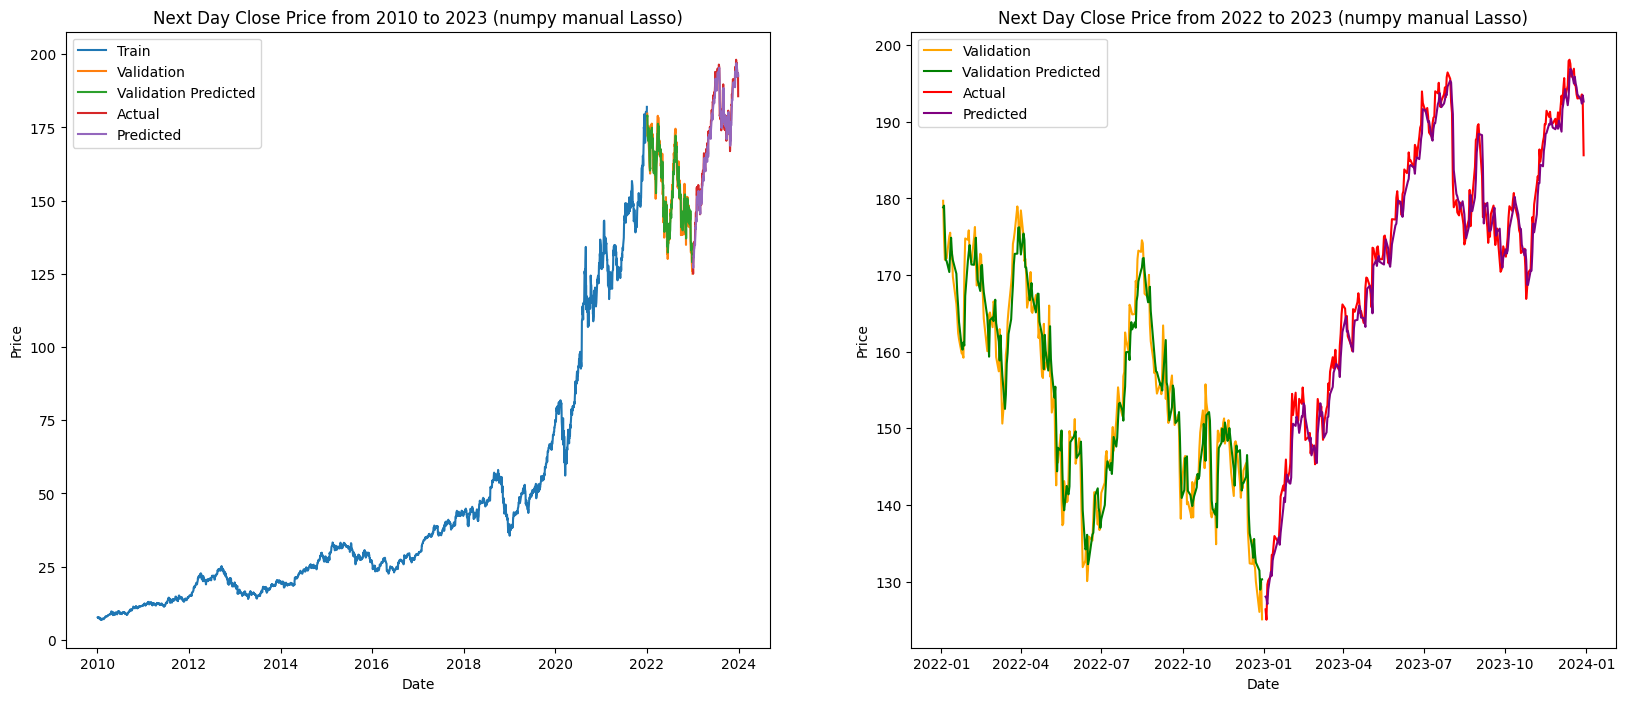

In [ ]:
X_train, X_val, X_test = map(lambda x: x.drop(['Close_next_day'], axis = 1), (df_train, df_val, df_test))
y_train, y_val, y_test = map(lambda x: x['Close_next_day'], (df_train, df_val, df_test))


cols = ['Model & Features Selected']
validation = ['Validation Error']
testing = ['Testing Error']
val, test = lasso_graphing(manual_lasso, X_train, X_val, X_test, y_train, y_val, y_test)
cols.append('Lasso Regression on\nAll Features')
validation.append(val)
testing.append(test)

# Ridge Regression

In [ ]:
class RidgeTorch:
  def __init__(self, learning_rate, l2_penalty):
    self.learning_rate = learning_rate
    self.l2_penalty = l2_penalty

  def fit( self, X, Y ) :
    # no_of_training_examples, no_of_features
    self.m, self.n = X.shape
    # weight initialization
    self.W = torch.zeros(self.n).double()
    self.b = 0
    self.X = torch.from_numpy(np.asarray(X))
    self.Y = torch.from_numpy(np.asarray(Y))
    # gradient descent learning
    for i in range(100):
      prev_W = torch.clone(self.W).detach()
      self.update_weights()
      # Check for convergence
      if torch.linalg.norm(prev_W - self.W) < 1e-4:
        print(f"Converged after {i+1} iterations.")
        break
    return self

  def update_weights(self):
    y_pred = torch.from_numpy(np.asarray(self.predict(self.X)))
    dW = ( - ( 2 * torch.matmul(torch.transpose(self.X, 0, 1), (self.Y - y_pred) )) +
               ( 2 * self.l2_penalty * self.W ) ) / self.m
    db = -2 * torch.sum(self.Y - y_pred) / self.m

    self.W = self.W - self.learning_rate * dW
    self.b = self.b - self.learning_rate * db
    return self

  def predict(self, X):
    # print('Shape of input:', X.shape)
    # print('Shape of weights:', self.W.shape)
    X = torch.from_numpy(np.asarray(X))
    matr = X.matmul(self.W)
    ans = matr + self.b
    return ans.detach().numpy()


In [ ]:
def manual_ridge(X_train, X_test, y_train, y_test, print_metrics = False):
  X_train, X_test = standard_scaler(X_train, X_test)
  X_train, X_test = np.array(X_train), np.array(X_test)
  y_train, y_test = np.array(y_train), np.array(y_test)
  learning_rate = [i / 1000 for i in range(70,101)] + [i / 1000 for i in range(130,170)]
  alphas = [i / 100 for i in range(0, 21, 5)] + [i / 10 for i in range(3, 10)] + [i for i in range(1, 51)]
  best = {'learning_rate': 0, 'l2_penalty': 0, 'mse': float('inf'), 'r2': float('-inf')}
  for lr in learning_rate:
    for alpha in alphas:
      ridge_model = RidgeTorch(learning_rate = lr, l2_penalty = alpha)
      ridge_model.fit(X_train, y_train)
      pred = ridge_model.predict(X_test)
      score_m = mean_squared_error(y_test, pred)
      score_r = r_squared(y_test, pred)
      if score_m < best['mse'] or score_r > best['r2']:
        best['learning_rate'] = lr
        best['l2_penalty'] = alpha
        best['mse'] = score_m
        best['r2'] = score_r
        # print(f'Best hyperparameter updated! Learning rate: {lr}, L2 Penalty: {alpha}, MSE: {score_m}')
  if print_metrics:
    print(f'Best metrics: {best}')
    print()
  ridge_model = RidgeTorch(learning_rate = best['learning_rate'], l2_penalty = best['l2_penalty'])
  ridge_model.fit(X_train, y_train)
  return ridge_model, 'pytorch manual Ridge'



In [ ]:
X_train, X_val = map(lambda x: x.drop(['Close_next_day'], axis = 1), (df_train, df_val))
y_train, y_val = map(lambda x: x['Close_next_day'], (df_train, df_val))

model_all, name = manual_ridge(X_train, X_val, y_train, y_val, print_metrics = True)

Best metrics: {'learning_rate': 0.075, 'l2_penalty': 0.0, 'mse': 20.14536690990571, 'r2': 0.8817192617828957}



In [ ]:
import matplotlib.pyplot as plt

def ridge_graphing(model, X_train, X_val, X_test, y_train, y_val, y_test):
  '''
  Performs iteration to find the best year to start predicting,
  then uses that year to build a model and graph out actual vs predicted
  '''
  dates_train = X_train.index
  dates_val = X_val.index
  dates_test = X_test.index

  print('Learning Rate:', model.learning_rate)
  print('L2 Penalty:', model.l2_penalty)
  _, X_val = standard_scaler(X_train, X_val)
  X_train, X_test = standard_scaler(X_train, X_test)
  y_val_pred = model.predict(X_val)
  y_pred = model.predict(X_test)

  val_mse = mean_squared_error(y_val, y_val_pred)
  test_mse = mean_squared_error(y_test, y_pred)
  print('Validation Loss (MSE):', val_mse)
  print('Testing Loss (MSE):', test_mse)

  fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,8))
  ax1.plot(dates_train, y_train)
  ax1.plot(dates_val, y_val)
  ax1.plot(dates_val, y_val_pred)
  ax1.plot(dates_test, y_test)
  ax1.plot(dates_test, y_pred)
  ax1.legend(['Train', 'Validation', 'Validation Predicted', 'Actual', 'Predicted'])
  ax1.set_xlabel('Date')
  ax1.set_ylabel('Price')
  ax1.set_title(f'Next Day Close Price from 2010 to 2023 ({name})')

  ax2.plot(dates_val, y_val, color = 'orange')
  ax2.plot(dates_val, y_val_pred, color = 'green')
  ax2.plot(dates_test, y_test, color = 'red')
  ax2.plot(dates_test, y_pred, color = 'purple')
  ax2.legend(['Validation', 'Validation Predicted', 'Actual', 'Predicted'])
  ax2.set_xlabel('Date')
  ax2.set_ylabel('Price')
  ax2.set_title(f'Next Day Close Price from 2022 to 2023 ({name})')
  return val_mse, test_mse

Learning Rate: 0.075
L2 Penalty: 0.0
Validation Loss (MSE): 20.14536690990571
Testing Loss (MSE): 13.961185665675442


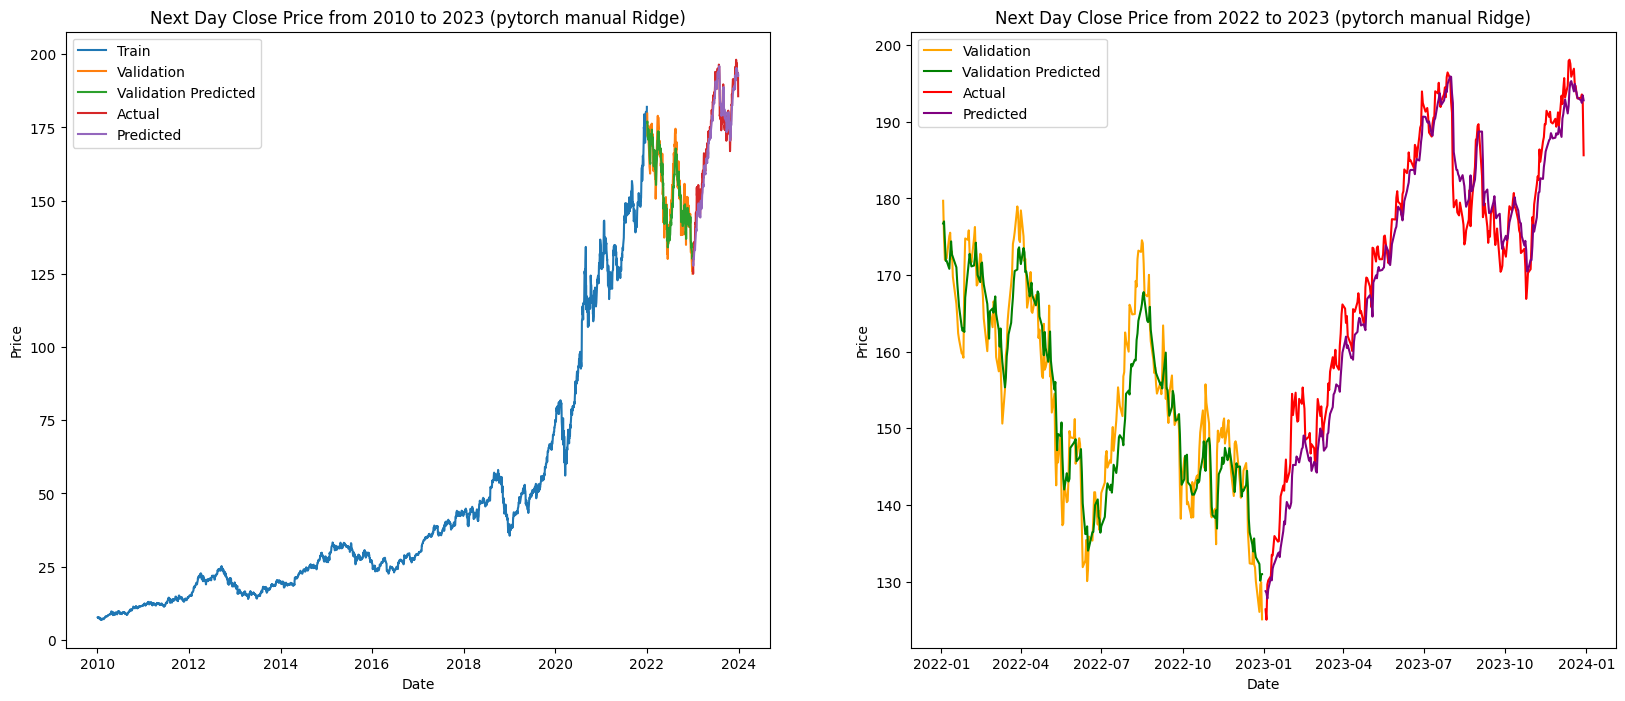

In [ ]:
X_train, X_val, X_test = map(lambda x: x.drop(['Close_next_day'], axis = 1), (df_train, df_val, df_test))
y_train, y_val, y_test = map(lambda x: x['Close_next_day'], (df_train, df_val, df_test))

val, test = ridge_graphing(model_all, X_train, X_val, X_test, y_train, y_val, y_test)
cols.append('Ridge Regression on\nAll Features')
validation.append(val)
testing.append(test)

## Feature Selection

In [ ]:
feature_selection.items()

dict_items([('info_gain', ['Close', 'High', 'Low', 'Adj Close', 'Open', 'ema_100', 'sma_100']), ('univariate', ['ema_50', 'Bolling', 'Open', 'High', 'Adj Close', 'Low', 'Close'])])

In [ ]:
X_train, X_val, X_test = map(lambda x: x[feature_selection['univariate']], (df_train, df_val, df_test))
y_train, y_val, y_test = map(lambda x: x['Close_next_day'], (df_train, df_val, df_test))

model_uni, name = manual_ridge(X_train, X_val, y_train, y_val, print_metrics = True)

Best metrics: {'learning_rate': 0.14, 'l2_penalty': 25, 'mse': 15.90532188053563, 'r2': 0.906614100302866}



Learning Rate: 0.14
L2 Penalty: 25
Validation Loss (MSE): 15.90532188053563
Testing Loss (MSE): 10.134309247749004


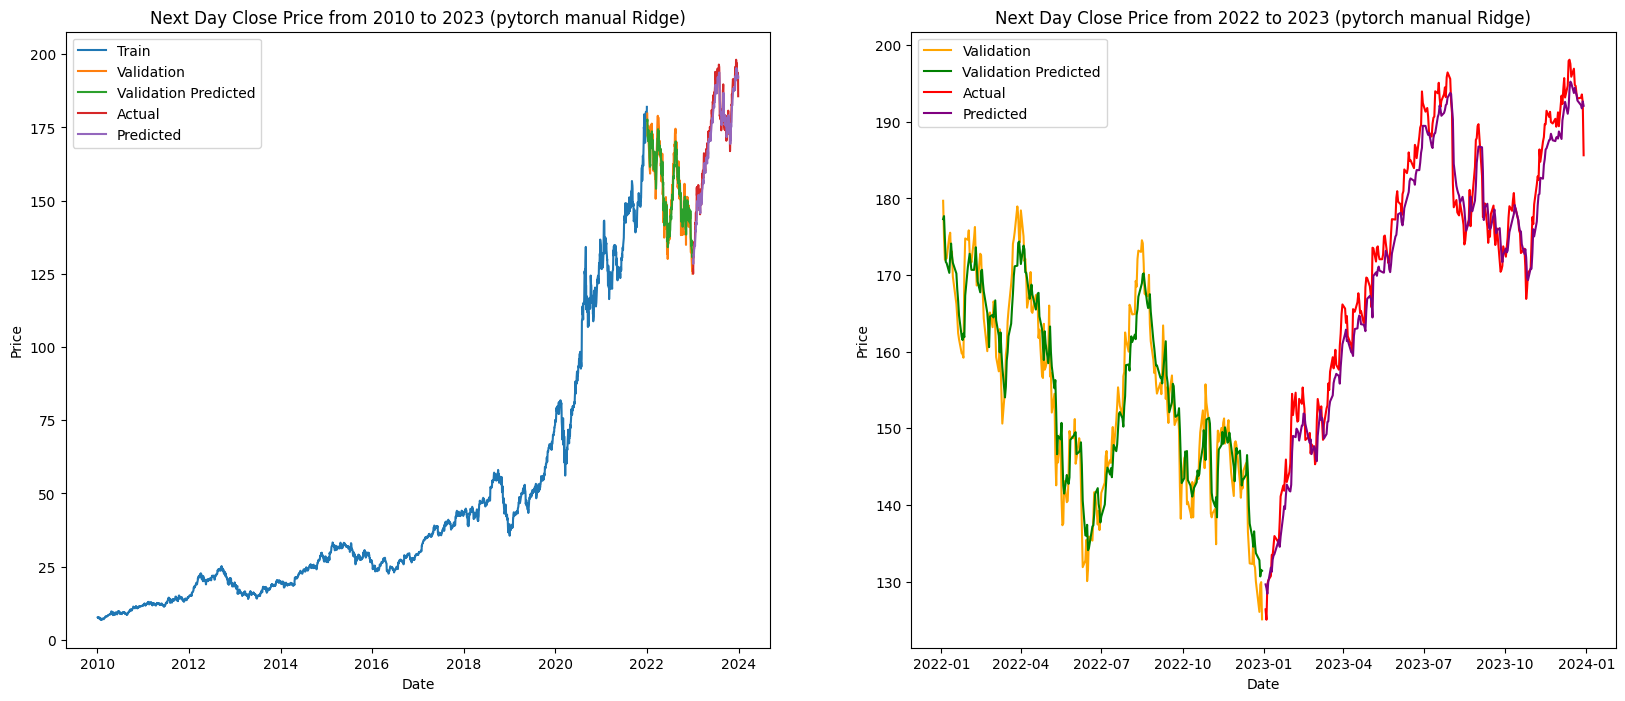

In [ ]:
val, test = ridge_graphing(model_uni, X_train, X_val, X_test, y_train, y_val, y_test)
cols.append('Ridge Regression on\nUnivariate Selection Features')
validation.append(val)
testing.append(test)

In [ ]:
X_train, X_val, X_test = map(lambda x: x[feature_selection['info_gain']], (df_train, df_val, df_test))
y_train, y_val, y_test = map(lambda x: x['Close_next_day'], (df_train, df_val, df_test))

model_info, name = manual_ridge(X_train, X_val, y_train, y_val, print_metrics = True)

Best metrics: {'learning_rate': 0.141, 'l2_penalty': 0.0, 'mse': 17.56890192062184, 'r2': 0.8968466199633602}



Learning Rate: 0.141
L2 Penalty: 0.0
Validation Loss (MSE): 17.56890192062184
Testing Loss (MSE): 22.441783299717592


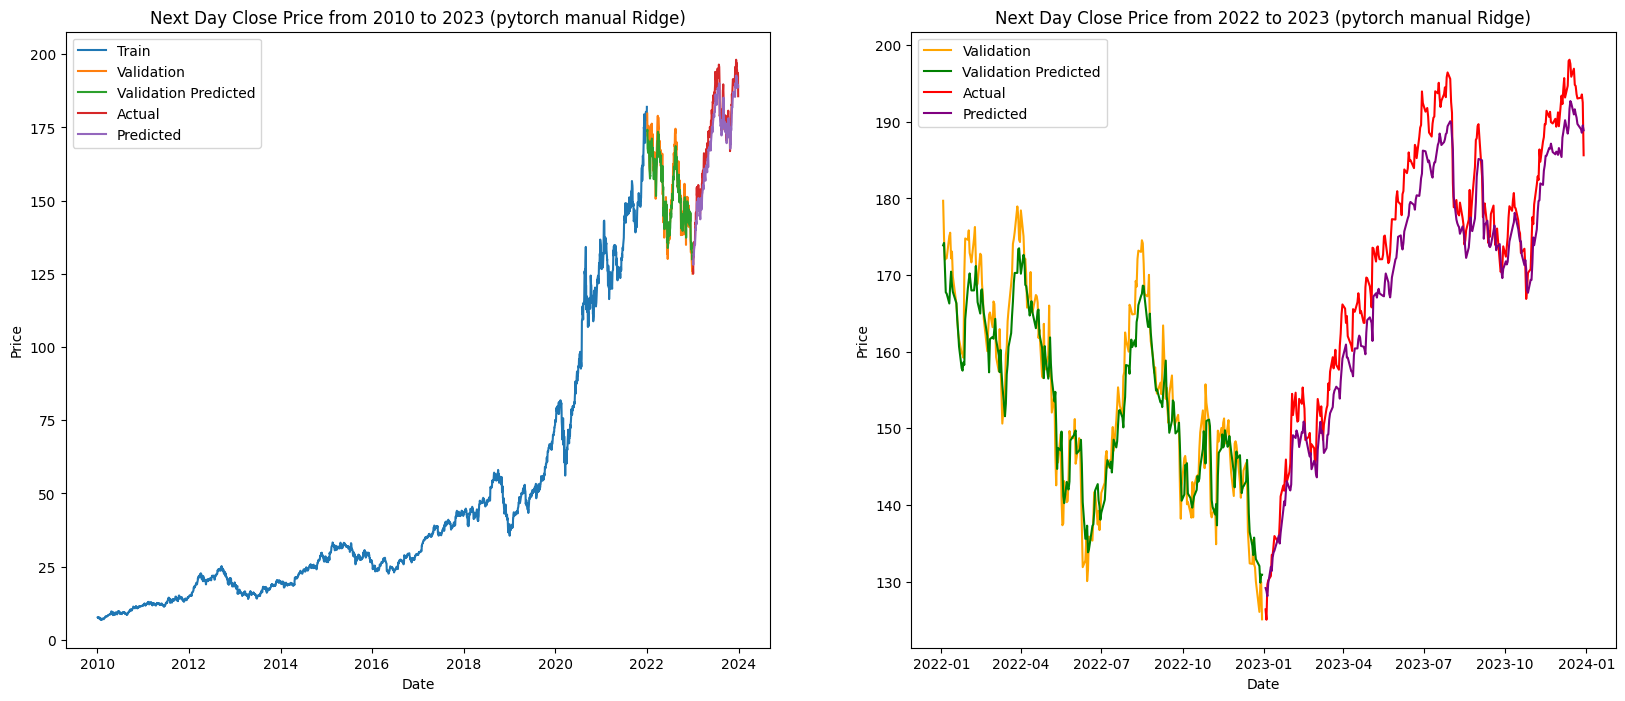

In [ ]:
val, test = ridge_graphing(model_info, X_train, X_val, X_test, y_train, y_val, y_test)
cols.append('Ridge Regression on\nInformation Gain Features')
validation.append(val)
testing.append(test)

In [ ]:
mse_df_pytorch = pd.DataFrame([validation, testing],
                      columns = cols)

## Plotting Loss to compare Feature Selection

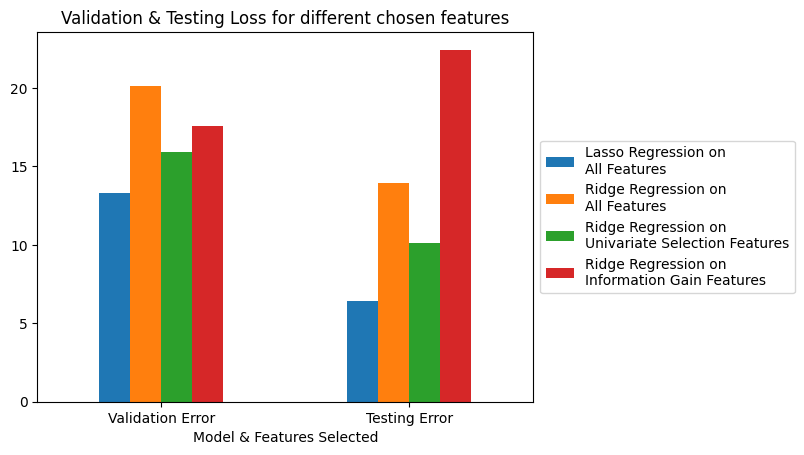

In [ ]:
mse_df_pytorch
mse_df_pytorch.plot.bar(x = 'Model & Features Selected', rot = 0,
            stacked = False,
            title = 'Validation & Testing Loss for different chosen features').legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))

# SVM


In [ ]:
class CustomSVR:
    def __init__(self, C=10, epsilon=0.1, n_iters=1000, learning_rate=0.01, batch_size=100, momentum=0.9):
        self.C = C
        self.epsilon = epsilon
        self.n_iters = n_iters
        self.lr = learning_rate
        self.batch_size = batch_size
        self.momentum = momentum
        self.weights = None
        self.bias = None
        self.velocity_w = None
        self.velocity_b = 0
        self.mse_history_train = []  # to store the training MSE after each epoch
        self.mse_history_val = []    # to store the validation MSE after each epoch

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        n_samples, n_features = X_train.shape
        self.weights = np.zeros(n_features)  # Initialize weights for each feature
        self.bias = 0
        self.velocity_w = np.zeros(n_features)
        best_val_mse = float('inf')
        best_weights = self.weights.copy()
        best_bias = self.bias

        for epoch in range(self.n_iters):
            np.random.seed(1)
            indices = np.random.permutation(n_samples)
            for batch_start in range(0, n_samples, self.batch_size):
                batch_indices = indices[batch_start:batch_start + self.batch_size]
                X_batch = X_train[batch_indices]
                y_batch = y_train[batch_indices]

                predictions = np.dot(X_batch, self.weights) + self.bias
                errors = predictions - y_batch

                mask = np.abs(errors) > self.epsilon
                errors_masked = errors[mask]
                X_masked = X_batch[mask]

                if len(errors_masked) > 0:
                    gradient_w = np.dot(X_masked.T, np.sign(errors_masked)) / len(X_masked)
                    gradient_b = np.sum(np.sign(errors_masked)) / len(X_masked)

                    self.velocity_w = self.momentum * self.velocity_w + self.lr * (self.C * np.sum(gradient_w) + 2 * self.weights / n_samples)
                    self.velocity_b = self.momentum * self.velocity_b + self.lr * gradient_b

                    self.weights -= self.velocity_w
                    self.bias -= self.velocity_b

            # Training and Validation MSE
            y_pred_train = self.predict(X_train)
            current_mse_train = mean_squared_error(y_train, y_pred_train)
            self.mse_history_train.append(current_mse_train)

            if X_val is not None and y_val is not None:
                y_pred_val = self.predict(X_val)
                current_mse_val = mean_squared_error(y_val, y_pred_val)
                self.mse_history_val.append(current_mse_val)

                if current_mse_val < best_val_mse:
                    best_val_mse = current_mse_val
                    best_weights = self.weights.copy()
                    best_bias = self.bias

                # Early stopping
                if len(self.mse_history_val) > 1 and self.mse_history_val[-1] > self.mse_history_val[-2]:
                    break

        self.weights = best_weights if best_weights is not None else self.weights
        self.bias = best_bias if best_bias is not None else self.bias

    def predict(self, X):
        if self.weights is None or self.bias is None:
            raise ValueError("Model is not fitted yet.")
        return np.dot(X, self.weights) + self.bias

    def score(self, X, y):
        y_pred = self.predict(X)
        return -mean_squared_error(y, y_pred)

    def get_params(self, deep=True):
        return {
            'C': self.C,
            'epsilon': self.epsilon,
            'n_iters': self.n_iters,
            'learning_rate': self.lr,
            'batch_size': self.batch_size,
            'momentum': self.momentum
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


##Using Selected Features (Mutual Info)

In [ ]:
X_train = df_train[['Close', 'High', 'Low', 'Adj Close', 'Open', 'ema_100', 'sma_100']].values
X_val = df_val[['Close', 'High', 'Low', 'Adj Close', 'Open', 'ema_100', 'sma_100']].values
X_test = df_test[['Close', 'High', 'Low', 'Adj Close', 'Open', 'ema_100', 'sma_100']].values
y_train, y_val, y_test = df_train['Close'].values, df_val['Close'].values, df_test['Close'].values
scaler = StandardScaler()
_, X_val = standard_scaler(X_train, X_val)
X_train, X_test = standard_scaler(X_train, X_test)
_, y_val = standard_scaler(y_train, y_val)
y_train, y_test = standard_scaler(y_train, y_test)

svr = CustomSVR(C=1, epsilon=0.1, n_iters=100, learning_rate=0.01, batch_size=100, momentum=0.9)
# Fit the model
svr.fit(X_train, y_train,X_val,y_val)

# Predict and evaluate
y_pred = svr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r2 = r_squared(y_test,y_pred)
print("R-Squared:", r2)


Mean Squared Error: 9.18408026747652
R-Squared: -43.50882225004235


##Using Selected Features (f-test)

In [ ]:
X_train = df_train[['ema_50', 'Bolling', 'Open', 'High', 'Adj Close', 'Low']].values
X_val = df_val[['ema_50', 'Bolling', 'Open', 'High', 'Adj Close', 'Low']].values
X_test = df_test[['ema_50', 'Bolling', 'Open', 'High', 'Adj Close', 'Low']].values
y_train, y_val, y_test = df_train['Close_next_day'].values, df_val['Close_next_day'].values, df_test['Close_next_day'].values
scaler = StandardScaler()
_, X_val = standard_scaler(X_train, X_val)
X_train, X_test = standard_scaler(X_train, X_test)
_, y_val = standard_scaler(y_train, y_val)
y_train, y_test = standard_scaler(y_train, y_test)

svr = CustomSVR(C=1, epsilon=0.1, n_iters=100, learning_rate=0.01, batch_size=100, momentum=0.9)
# Fit the model
svr.fit(X_train, y_train,X_val,y_val)

# Predict and evaluate
y_pred = svr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r2 = r_squared(y_test,y_pred)
print("R-Squared:", r2)


Mean Squared Error: 0.37341835082946745
R-Squared: -0.8696322563441556


##Reducing Features


In [ ]:
X_train = df_train[['Adj Close']].values
X_val = df_val[['Adj Close']].values
X_test = df_test[['Adj Close']].values
y_train, y_val, y_test = df_train['Close_next_day'].values, df_val['Close_next_day'].values, df_test['Close_next_day'].values
scaler = StandardScaler()
_, X_val = standard_scaler(X_train, X_val)
X_train, X_test = standard_scaler(X_train, X_test)
_, y_val = standard_scaler(y_train, y_val)
y_train, y_test = standard_scaler(y_train, y_test)

svr = CustomSVR(C=1, epsilon=0.1, n_iters=100, learning_rate=0.01, batch_size=100, momentum=0.9)
# Fit the model
svr.fit(X_train, y_train,X_val,y_val)

# Predict and evaluate
y_pred = svr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r2 = r_squared(y_test,y_pred)
print("R-Squared:", r2)


Mean Squared Error: 0.0033442864594615588
R-Squared: 0.983255815293556


In [ ]:
from sklearn.model_selection import GridSearchCV, KFold

# Define the parameter grid
param_grid = {
    'C': [1, 10, 100],
    'epsilon': [0.1, 0.5],
    'learning_rate': [0.01, 0.1]
}

# Optimized GridSearchCV setup
grid_search = GridSearchCV(
    estimator=CustomSVR(),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=KFold(n_splits=3),
    verbose=3,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'C': 1, 'epsilon': 0.1, 'learning_rate': 0.01}
Best score: -1.0


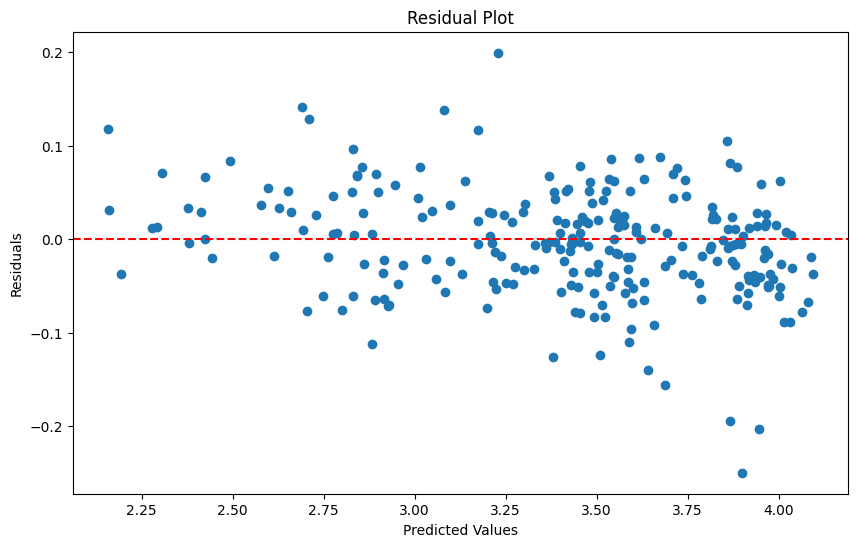

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_pred and y_test are defined
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


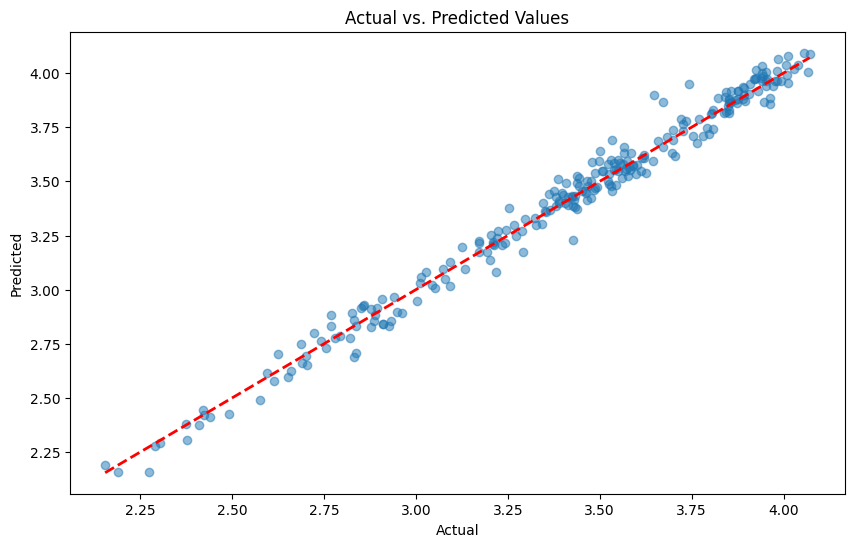

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, svr.predict(X_test), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()


In [ ]:
from sklearn.base import clone
from sklearn.utils import resample

class BaggingCustomSVR:
    def __init__(self, base_model, n_estimators=10):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.models = []

    def fit(self, X, y):
        self.models = []
        for _ in range(self.n_estimators):
            model = clone(self.base_model)
            X_sample, y_sample = resample(X, y)
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        return np.mean(predictions, axis=0)

In [ ]:
bagging_svr = BaggingCustomSVR(base_model=svr, n_estimators=10)
bagging_svr.fit(X_train, y_train)
y_pred_bagging = bagging_svr.predict(X_test)
mse_bagging = mean_squared_error(y_test, y_pred_bagging)
print(f'Bagging Mean Squared Error: {mse_bagging}')

Bagging Mean Squared Error: 11.809531445416193


#Neural Networks

In [ ]:
import numpy as np
import pandas as pd
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

X_train, X_val, X_test = df_train[['Close']].values, df_val[['Close']].values, df_test[['Close']].values
y_train, y_val, y_test = df_train['Close_next_day'].values, df_val['Close_next_day'].values, df_test['Close_next_day'].values

_, X_val = standard_scaler(X_train, X_val)
X_train, X_test = standard_scaler(X_train, X_test)
_, y_val = standard_scaler(y_train, y_val)
y_train, y_test = standard_scaler(y_train, y_test)

# Build the neural network model
model = Sequential([layers.Input((1,)),
                    layers.Dense(20, activation='relu'),
                    layers.Dense(1)])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
keras.utils.set_random_seed(1)
history = model.fit(X_train, y_train, epochs=30, validation_data = (X_val,y_val))

# Evaluate the model
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error:", mse)

X_train, X_val, X_test = df_train[['Close']].values, df_val[['Close']].values, df_test[['Close']].values
y_train, y_val, y_test = df_train['Close_next_day'].values, df_val['Close_next_day'].values, df_test['Close_next_day'].values

# Make predictions
predictions = model.predict(X_test)

Epoch 1/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.8532 - val_loss: 2.8672
Epoch 2/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1667 - val_loss: 0.4082
Epoch 3/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0240 - val_loss: 0.0770
Epoch 4/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0132 - val_loss: 0.0416
Epoch 5/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 - val_loss: 0.0300
Epoch 6/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085 - val_loss: 0.0221
Epoch 7/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - val_loss: 0.0181
Epoch 8/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - val_loss: 0.0157
Epoch 9/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 - val_loss: 0.0138
Epoch 10/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - val_loss: 0.0124
Epoch 11/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - val_loss: 0.0113
Epoch 12/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_lo

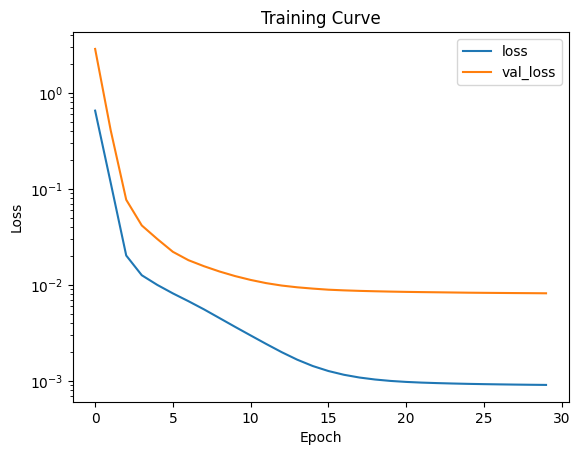

In [ ]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
plt.gca()
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.show()

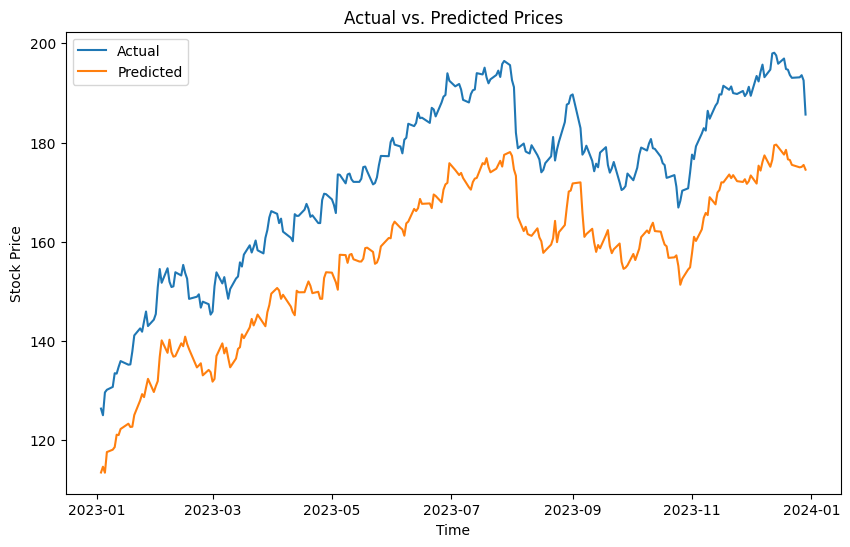

In [ ]:
testdates = []
for i in df_test.index:
  testdates.append(i)

plt.figure(figsize=(10,6))
plt.plot(testdates, y_test, label="Actual")
plt.plot(testdates, predictions, label="Predicted")
plt.title("Actual vs. Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

##Neural Networks using Selected Features (Mutual Info)

In [ ]:
X_train = df_train[['Close', 'High', 'Low', 'Adj Close', 'Open', 'ema_100', 'sma_100']].values
X_val = df_val[['Close', 'High', 'Low', 'Adj Close', 'Open', 'ema_100', 'sma_100']].values
X_test = df_test[['Close', 'High', 'Low', 'Adj Close', 'Open', 'ema_100', 'sma_100']].values
y_train, y_val, y_test = df_train['Close_next_day'].values, df_val['Close_next_day'].values, df_test['Close_next_day'].values

_, X_val = standard_scaler(X_train, X_val)
X_train, X_test = standard_scaler(X_train, X_test)
_, y_val = standard_scaler(y_train, y_val)
y_train, y_test = standard_scaler(y_train, y_test)

# Build the neural network model
model = Sequential([layers.Input((7,)),
                    layers.Dense(20, activation='relu'),
                    layers.Dense(1)])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
keras.utils.set_random_seed(1)
history = model.fit(X_train, y_train, epochs=30, validation_data = (X_val,y_val))

# Evaluate the model
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error:", mse)

X_train = df_train[['Close', 'High', 'Low', 'Adj Close', 'Open', 'ema_100', 'sma_100']].values
X_val = df_val[['Close', 'High', 'Low', 'Adj Close', 'Open', 'ema_100', 'sma_100']].values
X_test = df_test[['Close', 'High', 'Low', 'Adj Close', 'Open', 'ema_100', 'sma_100']].values
y_train, y_val, y_test = df_train['Close_next_day'].values, df_val['Close_next_day'].values, df_test['Close_next_day'].values

# Make predictions
predictions = model.predict(X_test)

Epoch 1/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5275 - val_loss: 0.0656
Epoch 2/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - val_loss: 0.0470
Epoch 3/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0034 - val_loss: 0.0442
Epoch 4/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - val_loss: 0.0390
Epoch 5/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - val_loss: 0.0354
Epoch 6/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021 - val_loss: 0.0336
Epoch 7/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0018 - val_loss: 0.0322
Epoch 8/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016 - val_loss: 0.0291
Epoch 9/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 0.0225
Epoch 10/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - val_loss: 0.0202
Epoch 11/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012 - val_loss: 0.0192
Epoch 12/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - val_lo

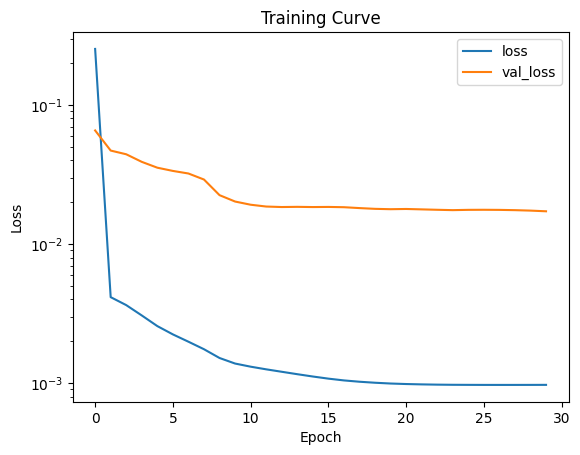

In [ ]:
pd.DataFrame(history.history).plot()
plt.gca()
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.show()

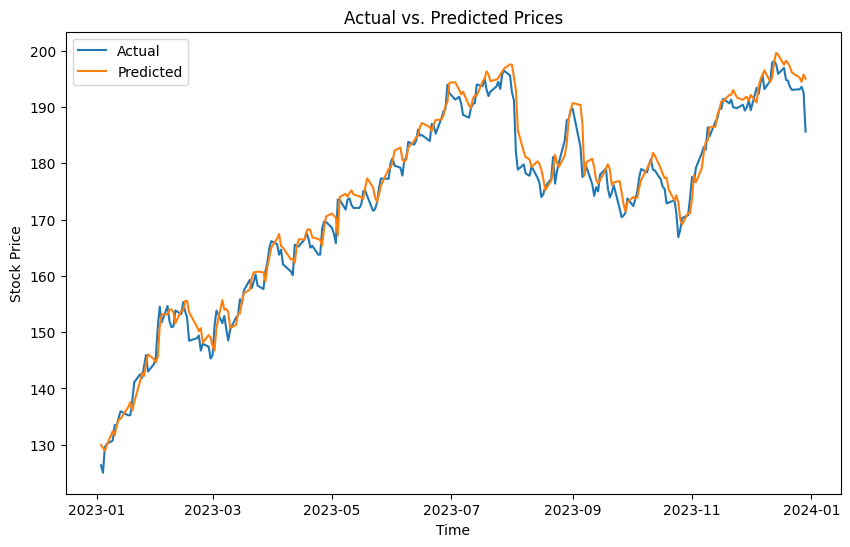

In [ ]:
testdates = []
for i in df_test.index:
  testdates.append(i)

plt.figure(figsize=(10,6))
plt.plot(testdates, y_test, label="Actual")
plt.plot(testdates, predictions, label="Predicted")
plt.title("Actual vs. Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

##Neural Networks using Selected Features (f-test)

In [ ]:
X_train = df_train[['ema_50', 'Bolling', 'Open', 'High', 'Adj Close', 'Low', 'Close']].values
X_val = df_val[['ema_50', 'Bolling', 'Open', 'High', 'Adj Close', 'Low', 'Close']].values
X_test = df_test[['ema_50', 'Bolling', 'Open', 'High', 'Adj Close', 'Low', 'Close']].values
y_train, y_val, y_test = df_train['Close_next_day'].values, df_val['Close_next_day'].values, df_test['Close_next_day'].values

_, X_val = standard_scaler(X_train, X_val)
X_train, X_test = standard_scaler(X_train, X_test)
_, y_val = standard_scaler(y_train, y_val)
y_train, y_test = standard_scaler(y_train, y_test)

# Build the neural network model
model = Sequential([layers.Input((7,)),
                    layers.Dense(20, activation='relu'),
                    layers.Dense(1)])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
keras.utils.set_random_seed(1)
history = model.fit(X_train, y_train, epochs=30, validation_data = (X_val,y_val))

# Evaluate the model
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error:", mse)

X_train = df_train[['ema_50', 'Bolling', 'Open', 'High', 'Adj Close', 'Low', 'Close']].values
X_val = df_val[['ema_50', 'Bolling', 'Open', 'High', 'Adj Close', 'Low', 'Close']].values
X_test = df_test[['ema_50', 'Bolling', 'Open', 'High', 'Adj Close', 'Low', 'Close']].values
y_train, y_val, y_test = df_train['Close_next_day'].values, df_val['Close_next_day'].values, df_test['Close_next_day'].values

# Make predictions
predictions = model.predict(X_test)

Epoch 1/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.5268 - val_loss: 0.0112
Epoch 2/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - val_loss: 0.0133
Epoch 3/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0023 - val_loss: 0.0131
Epoch 4/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0019 - val_loss: 0.0127
Epoch 5/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016 - val_loss: 0.0121
Epoch 6/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - val_loss: 0.0114
Epoch 7/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 0.0110
Epoch 8/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010 - val_loss: 0.0107
Epoch 9/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.7323e-04 - val_loss: 0.0104
Epoch 10/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.3608e-04 - val_loss: 0.0101
Epoch 11/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.1531e-04 - val_loss: 0.0101
Epoch 12/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.

Mean Squared Error: 0.0066033536568284035
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


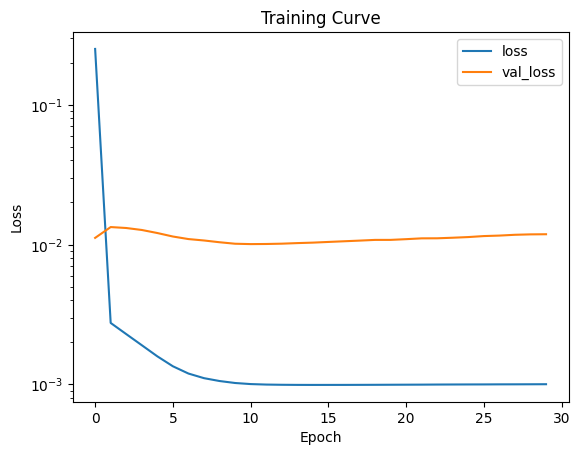

In [ ]:
pd.DataFrame(history.history).plot()
plt.gca()
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.show()

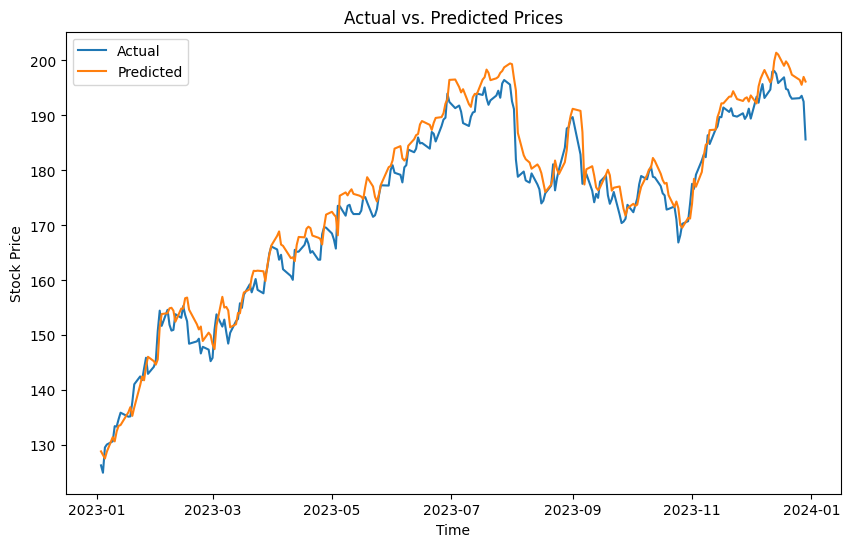

In [ ]:
testdates = []
for i in df_test.index:
  testdates.append(i)

plt.figure(figsize=(10,6))
plt.plot(testdates, y_test, label="Actual")
plt.plot(testdates, predictions, label="Predicted")
plt.title("Actual vs. Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()